In [1]:
import sys
sys.path.append("..")
from core.DataLoader import DataPreprocessor, DataConfig
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
MAX_JETS = 4
PLOTS_DIR = f"plots/"
import os
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)


2025-10-23 12:04:24.830373: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-23 12:04:24.835057: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-23 12:04:24.847219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761213864.866294 1198106 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761213864.872420 1198106 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761213864.887897 1198106 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
config = DataConfig(jet_features=["ordered_jet_pt","ordered_jet_eta", "ordered_jet_phi","ordered_jet_e","ordered_jet_b_tag","m_l2j","m_l1j","dR_l1j","dR_l2j"], 
                                lepton_features=["lep_pt", "lep_eta", "lep_phi", "lep_e", "lep_charge"],
                                jet_truth_label="ordered_event_jet_truth_idx", 
                                lepton_truth_label="event_lepton_truth_idx", 
                                met_features = ["met_met_NOSYS","met_phi_NOSYS"], 
                                max_leptons=2, 
                                max_jets = MAX_JETS, 
                                non_training_features =["truth_ttbar_mass", "truth_ttbar_pt", "N_jets", "dR_l1l2","Ttbar_MC_t_afterFSR_m","Ttbar_MC_tbar_afterFSR_m","Ttbar_MC_W_afterFSR_from_t_m","Ttbar_MC_W_afterFSR_from_tbar_m"], 
                                event_weight="weight_mc_NOSYS")

DataProcessor = DataPreprocessor(config)


DataProcessor.load_data("/data/dust/group/atlas/ttreco/full_training.root", "reco", max_events = 1000000)
#DataProcessor.plot_feature_correlation()


In [3]:
N_jets = DataProcessor.get_feature_data("non_training", "N_jets")

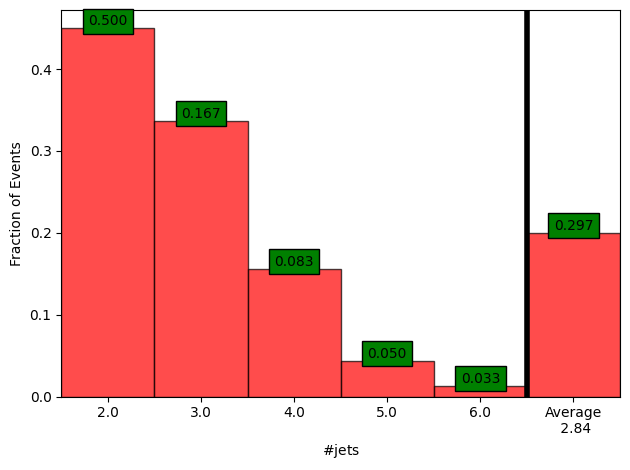

In [4]:
def assign_prob(n):
    return 1/(n*(n-1))
n_bins = 5
fig, ax = plt.subplots()
hist, bins = np.histogram(N_jets, bins = n_bins, range=(2,2 + n_bins), density=True)
assign_probs = assign_prob(bins[:-1])
bin_centers = (bins[:-1] + bins[1:])/2
bin_centers = np.concatenate([bin_centers, [bin_centers[-1] + 1]])
assign_probs = np.concatenate([assign_probs,[ np.dot(assign_probs, hist)]])
xtick_labels = np.concatenate([[f"{bins[i]}" for i in range(n_bins)], [f"Average\n {np.mean(N_jets):.2f}"]])

hist = np.concatenate([hist,[1/n_bins]])


bar = ax.bar(bin_centers,width=1,height = hist, align="center", edgecolor="black", color="red", alpha = 0.7)
for index,rect in enumerate(bar):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f"{assign_probs[index]:.3f}", ha='center', va='bottom', color="black", bbox = dict(facecolor="green"))

ax.axvline(x = bins[-1], color="black", linewidth=4)
ax.set_xticks(bin_centers)
ax.set_xticklabels(xtick_labels)
ax.set_xlim(2, 2 + n_bins + 1)
ax.set_ylabel("Fraction of Events")
ax.set_xlabel(r"$\#\text{jets}$")
fig.tight_layout()
fig.savefig(PLOTS_DIR + "Jet_multiplicity.png")


In [5]:
def compute_closest_non_matching_jet(data_dict, padding_value=-999):
    jet_eta = data_dict['jet'][:, :, 1]
    jet_phi = data_dict['jet'][:, :, 2]
    lep_eta = data_dict['lepton'][:,:, 1]
    lep_phi = data_dict['lepton'][:,:, 2]
    labels = data_dict['labels']
    compute_closest_non_matching_jet = np.full((jet_eta.shape[0], 2), -1, dtype=float)
    for i in range(jet_eta.shape[0]):
        for lep_idx in range(2):
            min_dR = float('inf')
            match_dR = -1
            for jet_idx in range(jet_eta.shape[1]):
                if jet_eta[i, jet_idx] == padding_value:
                    continue
                if labels[i,jet_idx, lep_idx]:
                    match_dR = np.sqrt((jet_eta[i, jet_idx] - lep_eta[i, lep_idx])**2 + (jet_phi[i, jet_idx] - lep_phi[i, lep_idx])**2)
                    continue
                dR = np.sqrt((jet_eta[i, jet_idx] - lep_eta[i, lep_idx])**2 + (jet_phi[i, jet_idx] - lep_phi[i, lep_idx])**2)
                if dR < min_dR and not labels[i,jet_idx, lep_idx]:
                    min_dR = dR
            compute_closest_non_matching_jet[i, lep_idx] = min_dR - match_dR
    return np.min(compute_closest_non_matching_jet, axis = 1)

In [6]:
import core.DataPlotting as DataPlotting
reload(DataPlotting)
data_plotter = DataPlotting.DataPlotter(DataProcessor, plots_dir=PLOTS_DIR)
data_plotter.add_feature(compute_closest_non_matching_jet, name="closest_non_matching")

In [7]:
DataProcessor.get_feature_data("custom", "closest_non_matching")

array([-1.60519817, -0.53983128,  1.59064256, ..., -1.63042961,
       -3.86747806, -4.37494157])

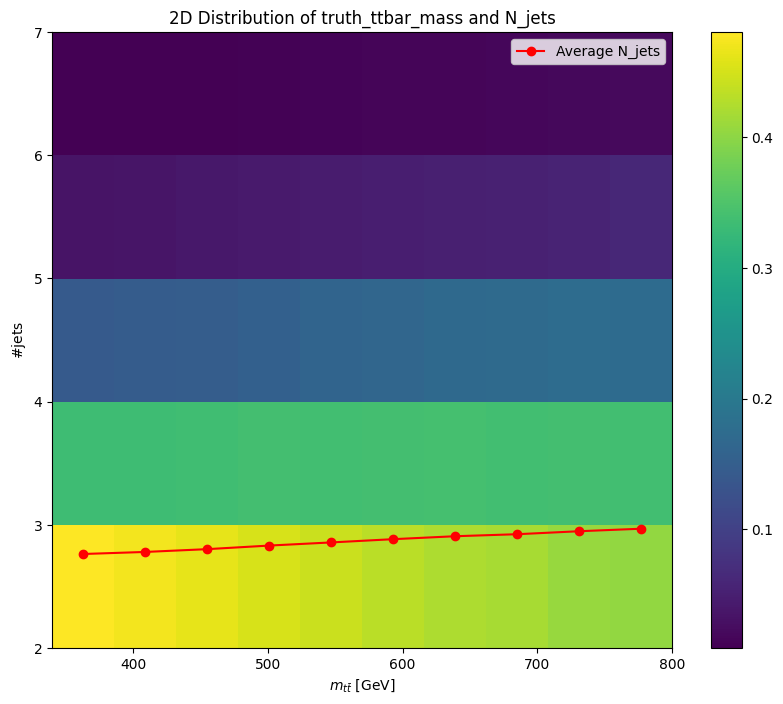

In [8]:
fig, ax = data_plotter.plot_2d_feature_distribution("non_training", "truth_ttbar_mass", "non_training", "N_jets", plot_average = True,normalise="x", bins=[10, 5], range =[[340e3, 800e3],[2, 7]])
x_ticks = ax.get_xticks()
x_tick_labels = [f"{int(x/1e3)}" for x in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xlim(340e3, 800e3)
ax.set_xticklabels(x_tick_labels)
ax.set_xlabel(r"$m_{t\bar{t}}$ [GeV]")
ax.set_ylabel(r"$\#\text{jets}$")
fig.savefig(PLOTS_DIR + "N_jets_vs_ttbar_mass.png")

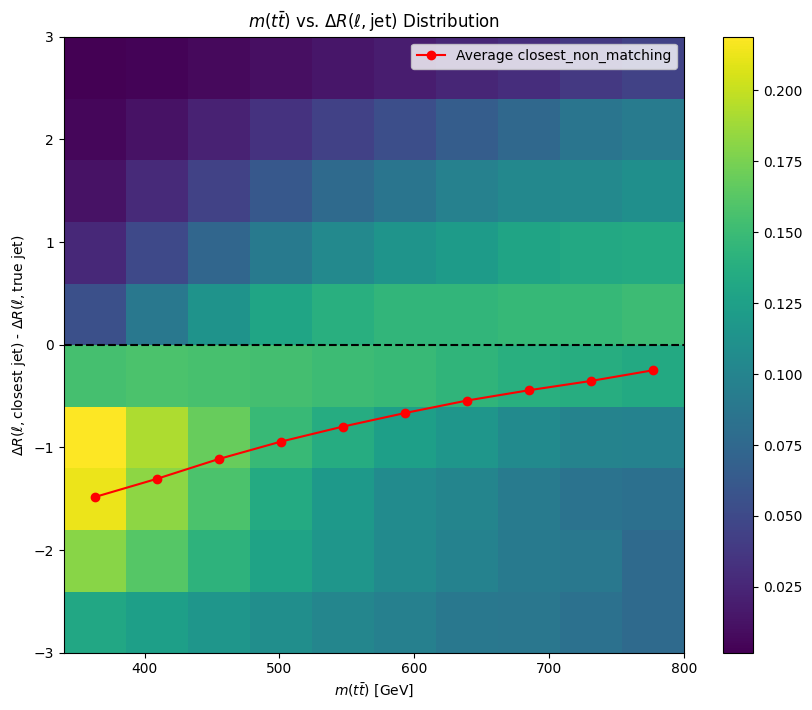

In [9]:
fig, ax = data_plotter.plot_2d_feature_distribution("non_training", "truth_ttbar_mass", "custom", "closest_non_matching", plot_average=True,normalise="x", bins=10, range =[[340e3, 800e3],[-3, 3]], density = True)
x_ticks = ax.get_xticks()
x_tick_labels = [f"{int(tick/1e3)}" for tick in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlim(340e3, 800e3)
ax.set_xlabel(r"$m(t\bar{t})$ [GeV]")
ax.set_ylabel(r"$\Delta R(\ell,\text{closest jet})$ - $\Delta R(\ell,\text{true jet})$")
ax.set_title(r"$m(t\bar{t})$ vs. $\Delta R(\ell, \text{jet})$ Distribution")
plt.savefig(f"{PLOTS_DIR}/ttbar_mass_vs_deltaR_lep_nonmatch.png")

In [12]:
data_plotter.register_data_cut("non_training", "N_jets", lambda x: x == 2)
fig, ax = data_plotter.plot_2d_feature_distribution("non_training", "truth_ttbar_mass", "custom", "closest_non_matching", plot_average=True,normalise="x", bins=10, range =[[340e3, 800e3],[-3, 3]], density = True)
x_ticks = ax.get_xticks()
x_tick_labels = [f"{int(tick/1e3)}" for tick in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlim(340e3, 800e3)
ax.set_xlabel(r"$m(t\bar{t})$ [GeV]")
ax.set_ylabel(r"$\Delta R(\ell,\text{closest jet})$ - $\Delta R(\ell,\text{true jet})$")
ax.set_title(r"$m(t\bar{t})$ vs. $\Delta R(\ell, \text{jet})$ Distribution (N_jets = 2)")
plt.savefig(f"{PLOTS_DIR}/ttbar_mass_vs_deltaR_lep_nonmatch_n_jet_2.png")

ValueError: operands could not be broadcast together with shapes (994735,) (151134,) 

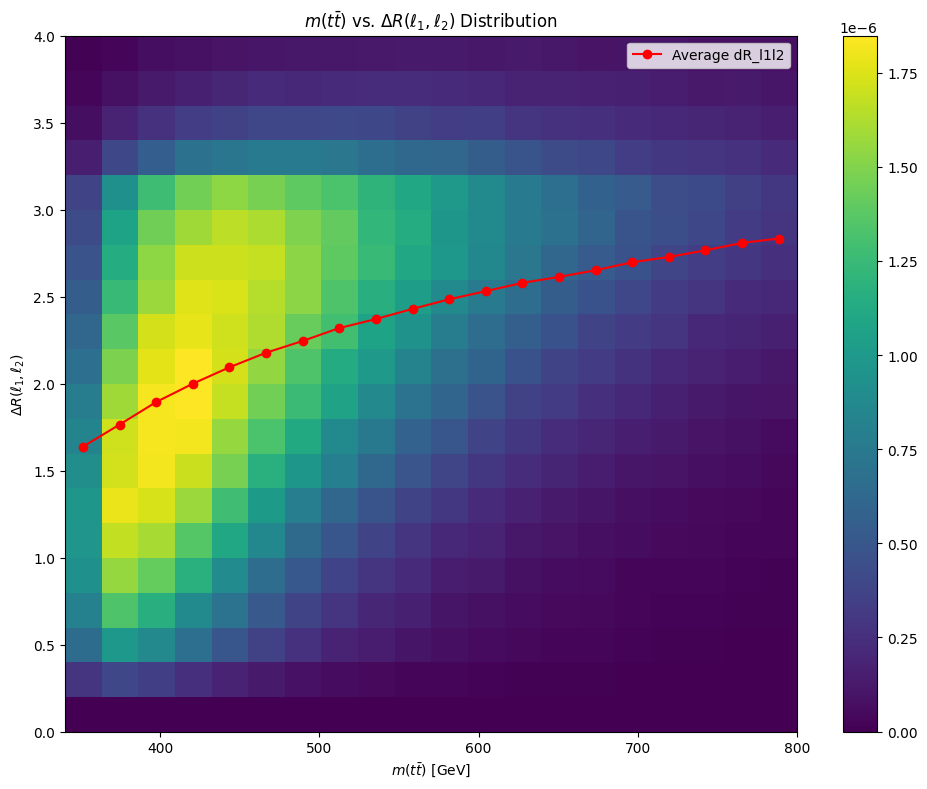

In [10]:
data_plotter.reset_data_cuts()
fig, ax = data_plotter.plot_2d_feature_distribution("non_training", "truth_ttbar_mass", "non_training", "dR_l1l2", bins=(20, 20), plot_average=True, range =[[ 340e3, 800e3],[0, 4]], density = True)
x_ticks = ax.get_xticks()
x_tick_labels = [f"{int(tick/1e3)}" for tick in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.set_xlim(340e3, 800e3)
ax.set_xlabel(r"$m(t\bar{t})$ [GeV]")
ax.set_ylabel(r"$\Delta R(\ell_1, \ell_2)$")
ax.set_title(r"$m(t\bar{t})$ vs. $\Delta R(\ell_1, \ell_2)$ Distribution")
#fig.suptitle(r"$m(t\bar{t})$ vs. $\Delta R(\ell_1, \ell_2)$ Distribution")
fig.tight_layout()
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_vs_dR_l1l2.png")



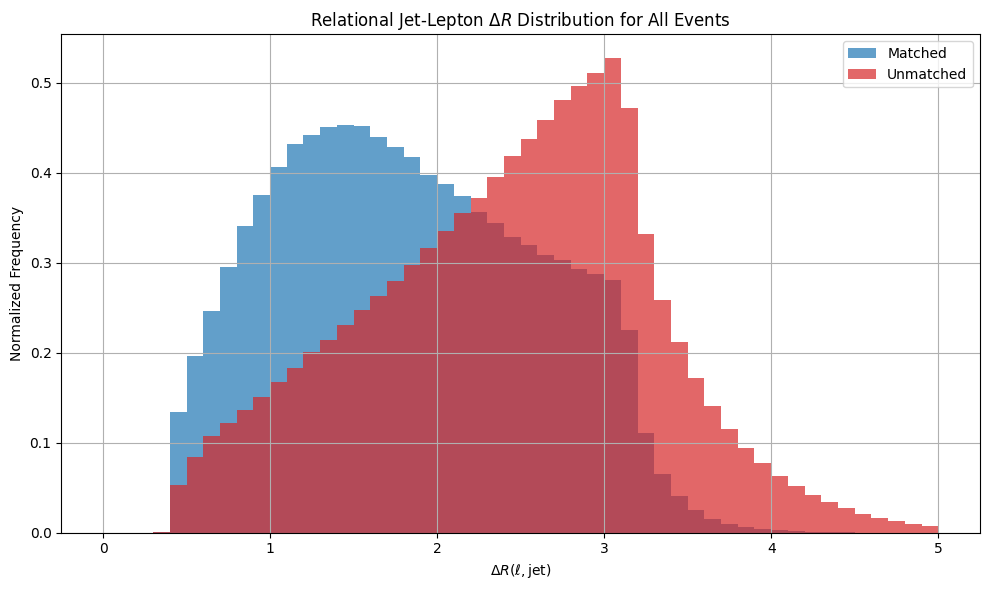

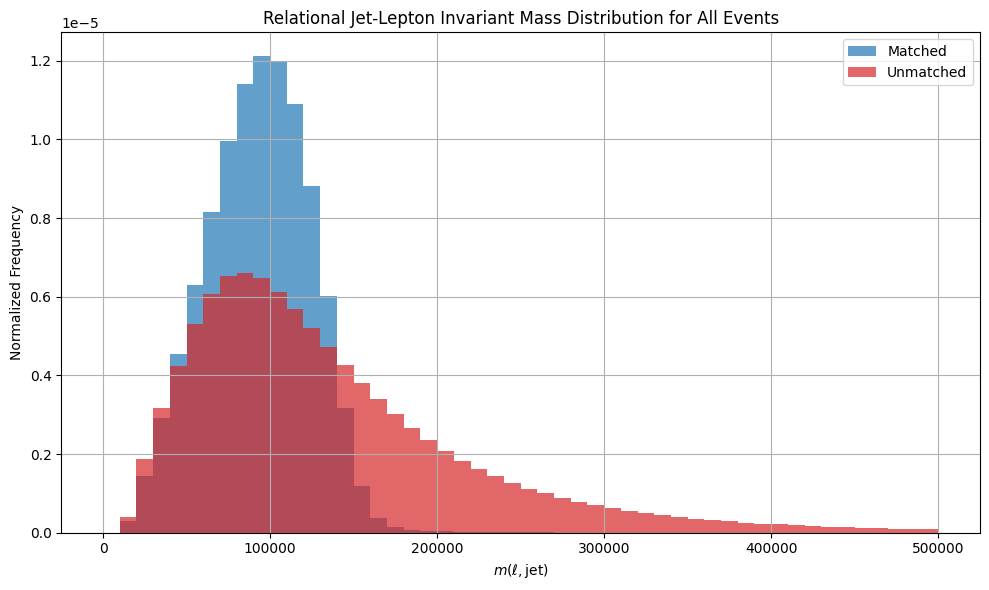

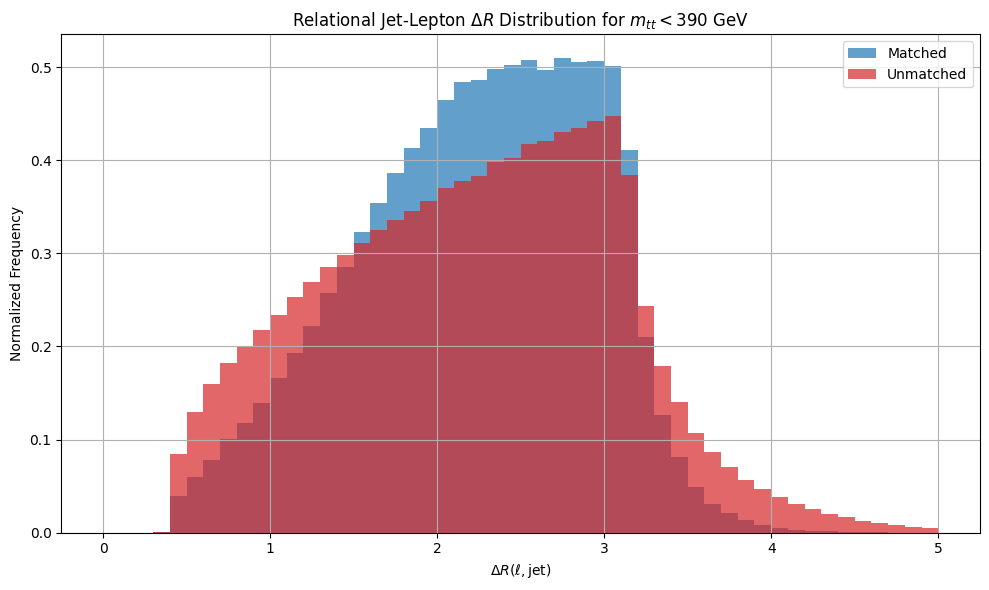

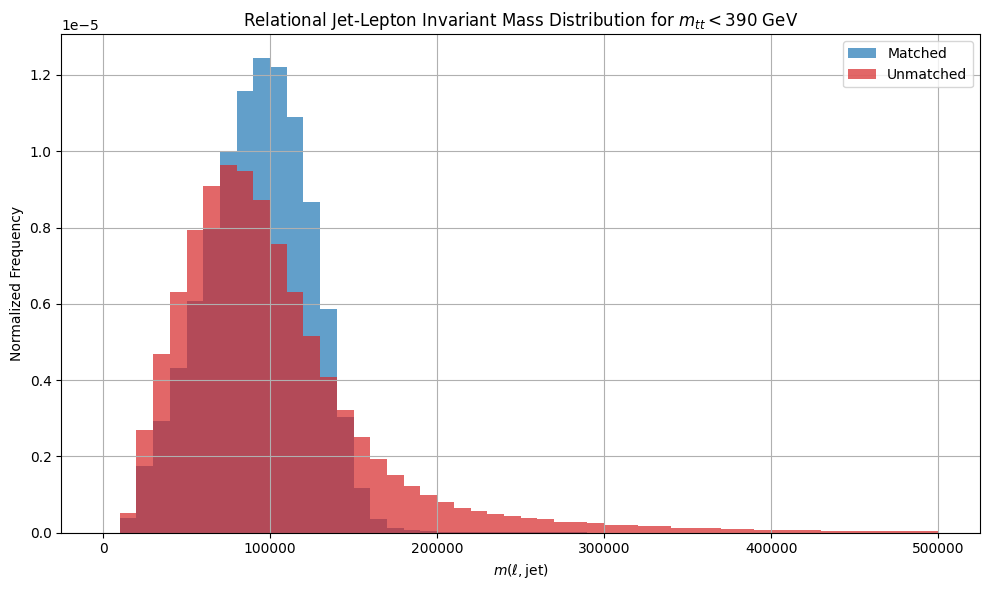

In [11]:
def delta_R(jet_features, lepton_features):
    delta_eta = jet_features[1] - lepton_features[1]
    delta_phi = jet_features[2] - lepton_features[2]
    delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def invariant_mass(jet_features, lepton_features):
    jet_e = jet_features[3]
    jet_px = jet_features[0] * np.cos(jet_features[2])
    jet_py = jet_features[0] * np.sin(jet_features[2])
    jet_pz = jet_features[0] * np.sinh(jet_features[1])

    lep_e = lepton_features[3]
    lep_px = lepton_features[0] * np.cos(lepton_features[2])
    lep_py = lepton_features[0] * np.sin(lepton_features[2])
    lep_pz = lepton_features[0] * np.sinh(lepton_features[1])

    total_e = jet_e + lep_e
    total_px = jet_px + lep_px
    total_py = jet_py + lep_py
    total_pz = jet_pz + lep_pz

    return np.sqrt(total_e**2 - total_px**2 - total_py**2 - total_pz**2)

fig, ax = data_plotter.plot_relational_jet_lepton_features(delta_R, r"$\Delta R(\ell, \text{jet})$", bins=50, range=(0, 5))
ax.set_title("Relational Jet-Lepton $\Delta R$ Distribution for All Events")
fig.tight_layout()
fig.savefig(PLOTS_DIR + "relational_jet_lepton_deltaR_distribution.png")
fig, ax = data_plotter.plot_relational_jet_lepton_features(invariant_mass, r"$m(\ell, \text{jet})$", bins=50, range=(0, 500e3))
ax.set_title("Relational Jet-Lepton Invariant Mass Distribution for All Events")
fig.tight_layout()
fig.savefig(PLOTS_DIR + "relational_jet_lepton_invariant_mass_distribution.png")



# For m_tt < 390 GeV
data_plotter.register_data_cut("non_training", "truth_ttbar_mass", lambda x: x < 390e3)
fig, ax = data_plotter.plot_relational_jet_lepton_features(delta_R, r"$\Delta R(\ell, \text{jet})$", bins=50, range=(0, 5))
ax.set_title(r"Relational Jet-Lepton $\Delta R$ Distribution for $m_{tt} < 390$ GeV")
fig.tight_layout()
fig.savefig(PLOTS_DIR + "relational_jet_lepton_deltaR_distribution_m_tt_390GeV.png")
fig, ax = data_plotter.plot_relational_jet_lepton_features(invariant_mass, r"$m(\ell, \text{jet})$", bins=50, range=(0, 500e3))
ax.set_title(r"Relational Jet-Lepton Invariant Mass Distribution for $m_{tt} < 390$ GeV")
fig.tight_layout()
fig.savefig(PLOTS_DIR + "relational_jet_lepton_invariant_mass_distribution_m_tt_390GeV.png")
